In [9]:
%matplotlib inline
import netCDF4 as nc
from ftplib import FTP
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from IPython.display import HTML
from datetime import date, timedelta
import h5py
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
# matplotlib.use('webagg')
import shapefile as shp
from descartes import PolygonPatch
from matplotlib.colors import LinearSegmentedColormap


# from PYOPATRA import *

In [10]:
total_days = 8 * 7 
times = ['000', '003', '006', '009', '012', '015', '018', '021']
start_date = date(2010, 4, 20)

In [11]:
with nc.Dataset('data/hycom_gomu_501_2010042000_t000.nc') as ds:
    shape = (ds['lat'].shape[0], ds['lon'].shape[0])
    lon = np.array(ds['lon'][:])
    lat = np.array(ds['lat'][:])
    
print(shape)
    
velocity = np.zeros((2, *shape, len(times) * total_days), dtype='float32')
file_list = []

for days_since_start in range(total_days):
    cur_date = start_date + timedelta(days=days_since_start)
    
    for time_index, time_str in enumerate(times):
        file = 'data/hycom_gomu_501_{}{:02d}{:02d}00_t{}.nc'.format(cur_date.year, cur_date.month, cur_date.day, time_str)
        file_list.append(file)
        
        with nc.Dataset(file) as ds:
            velocity[0, :, :, days_since_start * len(times) + time_index] = ds['water_u'][0, 0, :, :] 
            velocity[1, :, :, days_since_start * len(times) + time_index] = ds['water_v'][0, 0, :, :]  
            
            velocity[0, :, :, days_since_start * len(times) + time_index][velocity[0, :, :, days_since_start * len(times) + time_index] == ds['water_u'].missing_value] = float('NaN')
            velocity[1, :, :, days_since_start * len(times) + time_index][velocity[1, :, :, days_since_start * len(times) + time_index] == ds['water_v'].missing_value] = float('NaN')


np.save('velocity.npy', velocity)
np.save('lat.npy', lat[:])
np.save('lon.npy', lon[:])

(346, 541)


In [12]:
with h5py.File('data/snapshots.hdf5', 'r') as fp:
    particle_snapshots = fp['snapshots'][:, :, :]

In [13]:
with h5py.File('data/observed_particles.hdf5', 'r') as fp:
    particles = fp['particles'][:, :]
    
print(particles.shape)

(71520, 2)


In [14]:
shp_start_date = date(2010, 6, 13)

shapes = []

for i in range(11):
    current_date = shp_start_date + timedelta(days=i)
    
    with shp.Reader("data/shapefiles/S_{}_{}.shp".format(current_date.month, current_date.day)) as sf:
        shapes.append({
            'date': current_date,
            'shape_records': sf.shapeRecords()
        })

In [15]:
cmap_nodes = [0.0, 1.0]
# cmap_colors = [(232 / 255, 117 / 255, 0, 0.0), (232 / 255, 117 / 255, 0, 1.0)]
cmap_colors = [(0, 0, 0, 0.0), (0, 0, 0, 1.0)]

my_cmap = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

Before (71520, 2)
After (70560, 2)


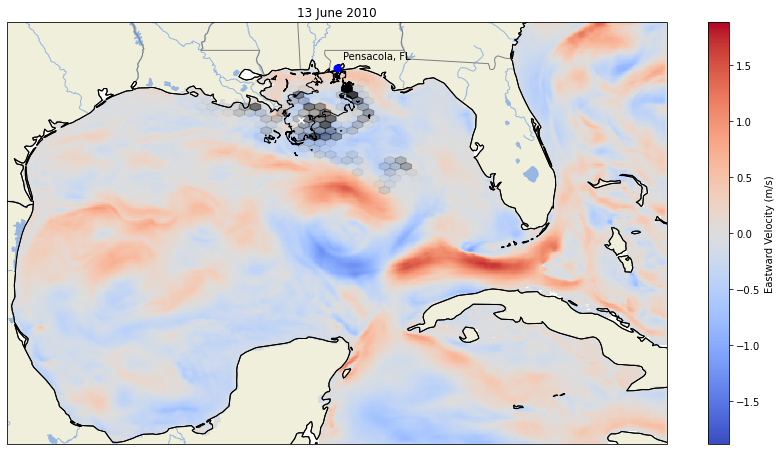

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7), subplot_kw={'projection': ccrs.PlateCarree()})

num_snapshots = ((shp_start_date - start_date).days + 1) * len(times)

particle_cmap = matplotlib.cm.get_cmap('Purples')

def normalize(position):
    return position / num_snapshots

extent = np.nanmax(np.abs((np.nanmin(velocity[0, :, :, num_snapshots]), np.nanmax(velocity[0, :, :, num_snapshots]))))

im = ax.pcolormesh(lon, lat, velocity[0, :, :, num_snapshots], vmin=-extent, vmax=extent, rasterized=True, cmap='coolwarm')
# for i in range(num_snapshots * 10):
#     ax.scatter(particle_snapshots[i, 1, num_snapshots], particle_snapshots[i, 0, num_snapshots], color=particle_cmap(normalize(i)))
snapshots = particle_snapshots[:, :, num_snapshots]
print('Before', snapshots.shape)
snapshots = snapshots[~np.all(particle_snapshots[:, :, num_snapshots] == 0, axis=1)]
print('After', snapshots.shape)
ax.hexbin(snapshots[:, 1], snapshots[:, 0], cmap=my_cmap, gridsize=30)
ax.scatter(-88.365997, 28.736628, marker='x', color='white')
ax.coastlines(resolution='50m', color='black', linewidth=1)

fig.colorbar(im, label='Eastward Velocity (m/s)')

countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none'
)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(countries, edgecolor='black')
ax.set_xlim(lon[0], lon[-1])
ax.set_ylim(lat[0], lat[-1])

current_shapes = list(filter(lambda shape_dict : shape_dict['date'] == shp_start_date, shapes))

for shape in current_shapes[0]['shape_records']:
    poly = shape.__geo_interface__['geometry']
    ax.add_patch(PolygonPatch(poly, ec='black', fc='none'))


ax.set_title('13 June 2010')

pen_lon = -87.2
pen_lat = 30.433333

ax.plot(-87.2, 30.433333, 'bo', markersize=7)
ax.text(-87, 30.7, 'Pensacola, FL')

fig.tight_layout()

fig.savefig('spill.png', dpi=300)

-1.7990001 2.5960002 448


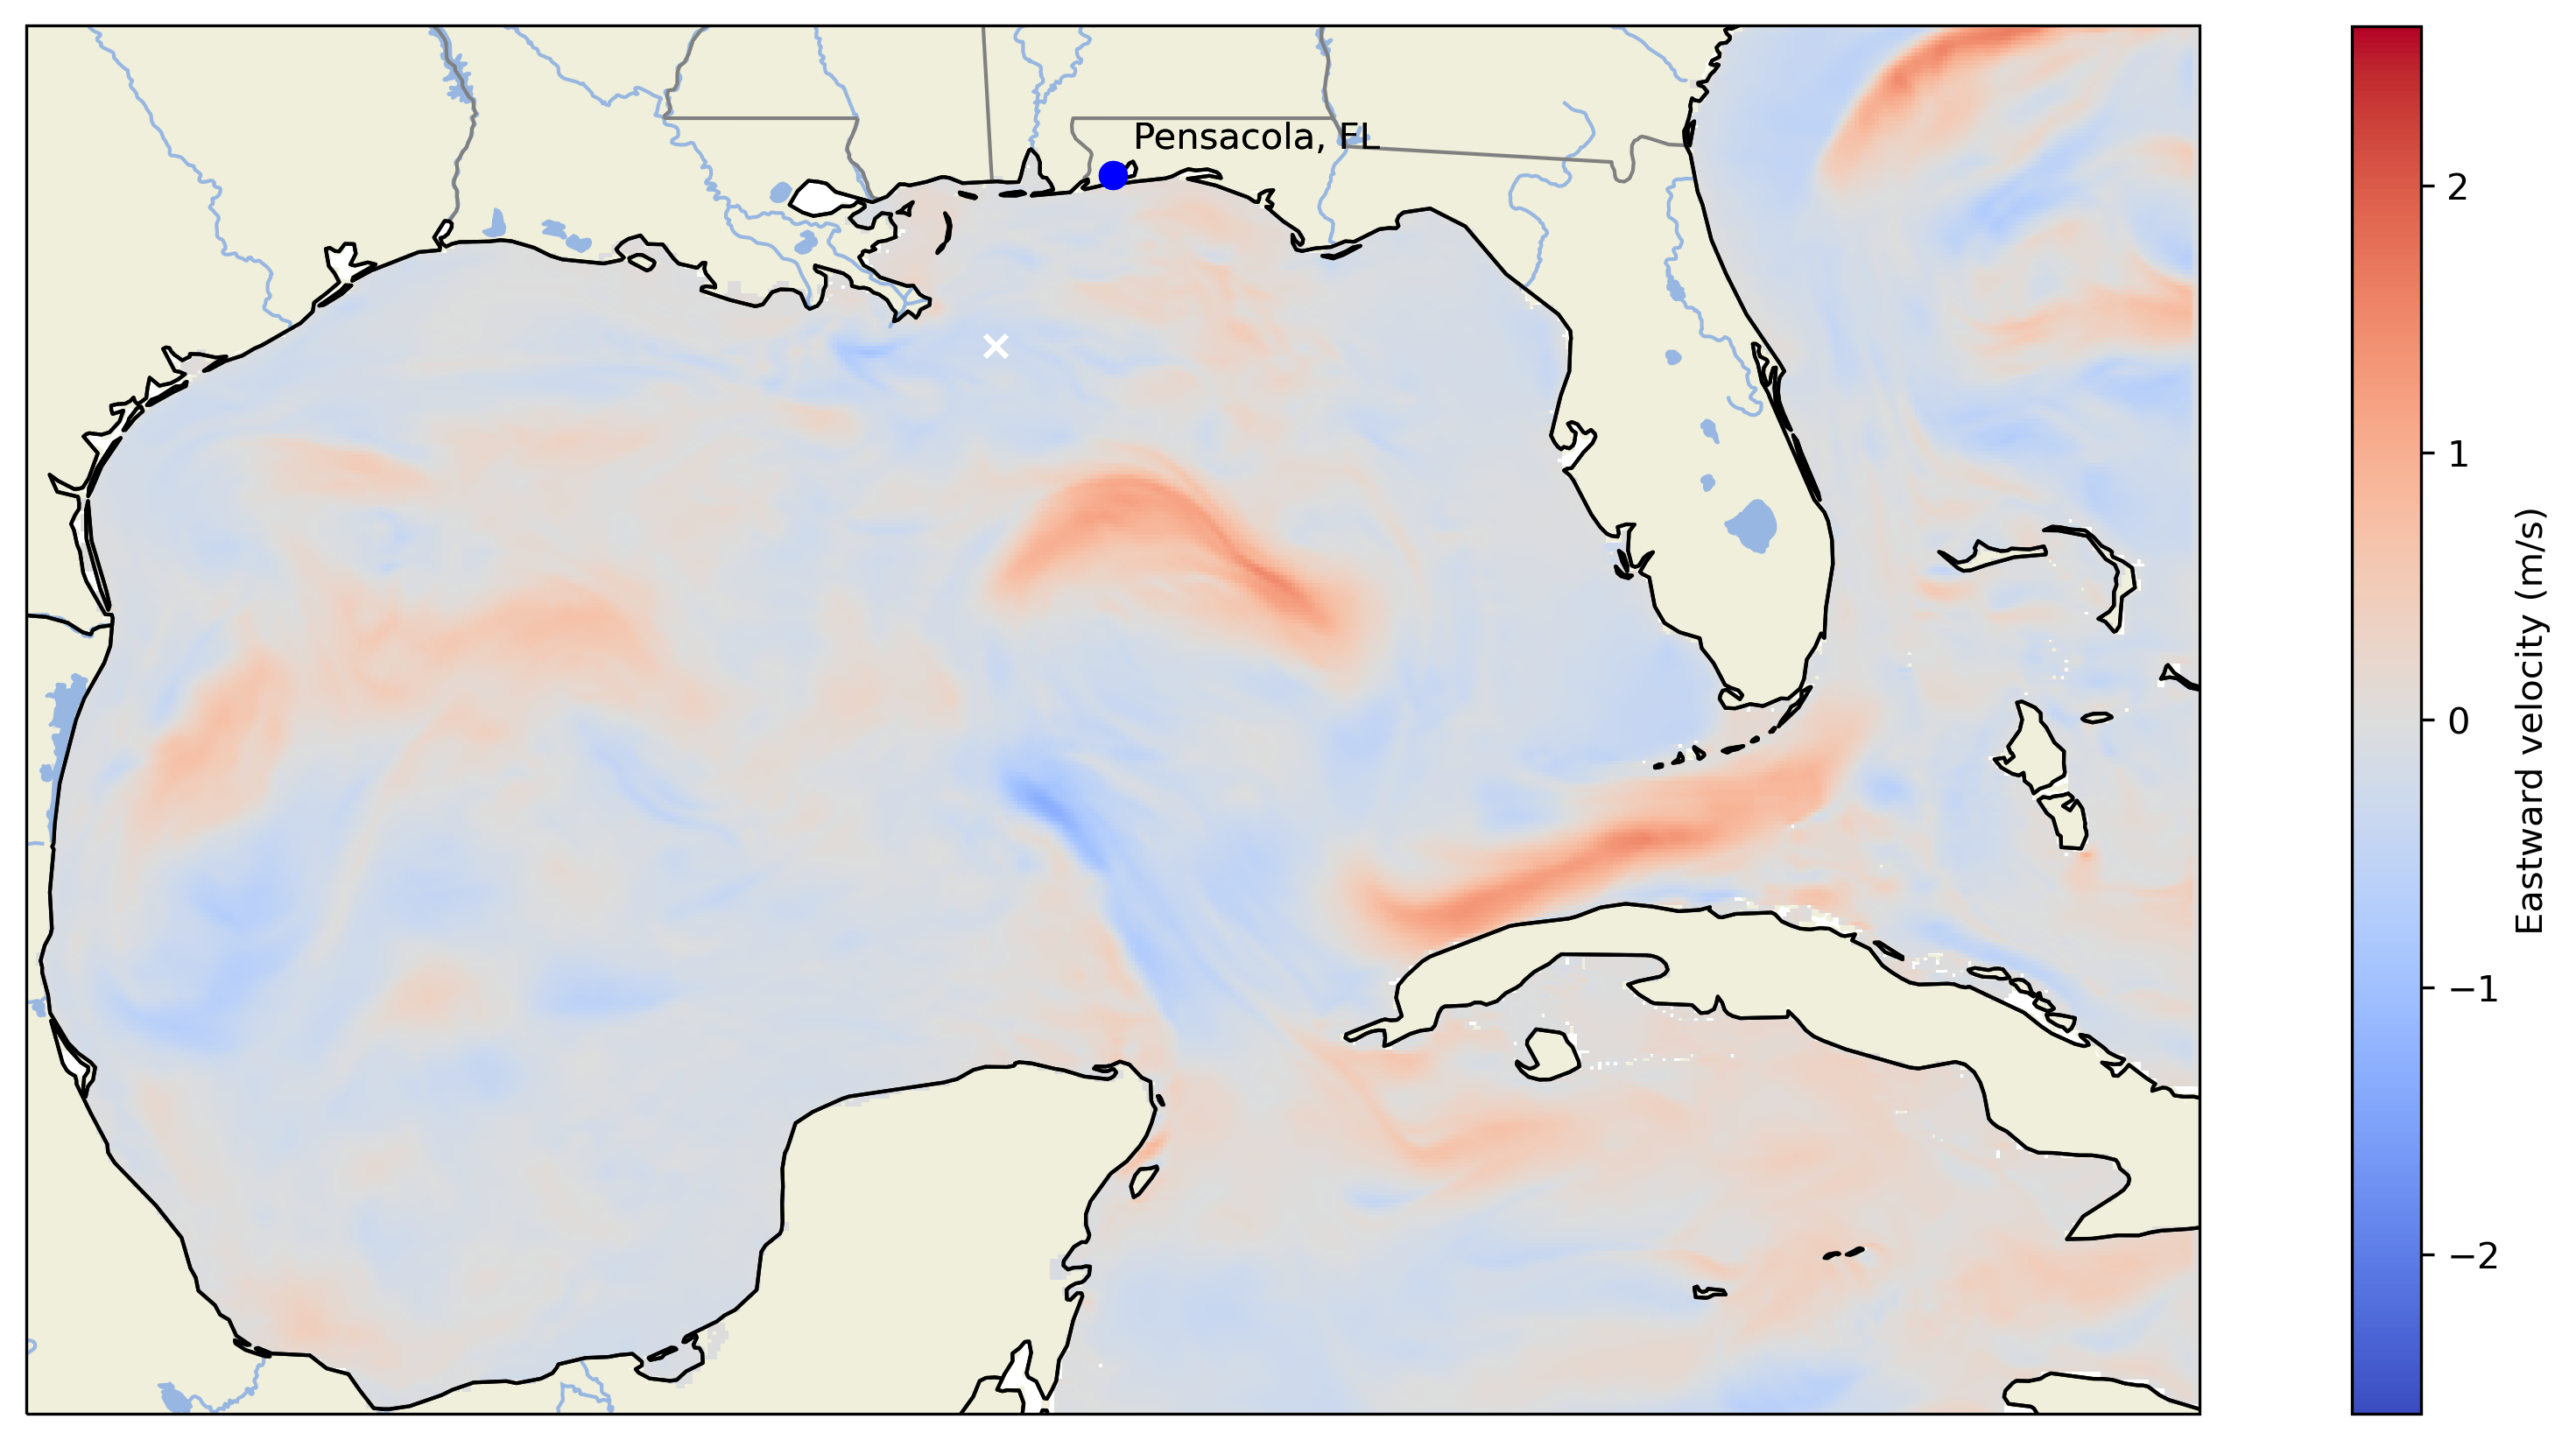

In [9]:
# plt.rc('animation')

fig, ax = plt.subplots(1, 1, figsize=(15, 7), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)

vmin = np.nanmin(velocity[0, :, :, :])
vmax = np.nanmax(velocity[0, :, :, :])

extent = np.max((np.abs(vmin), np.max(vmax)))

ax.coastlines(resolution='50m', color='black', linewidth=1)

countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    facecolor='none'
)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(countries, edgecolor='black')
ax.set_xlim(lon[0], lon[-1])
ax.set_ylim(lat[0], lat[-1])

pen_lon = -87.2
pen_lat = 30.433333

ax.plot(-87.2, 30.433333, 'bo', markersize=7)
ax.text(-87, 30.7, 'Pensacola, FL')

pen_lon = -87.2
pen_lat = 30.433333

ax.plot(-87.2, 30.433333, 'bo', markersize=7)
ax.text(-87, 30.7, 'Pensacola, FL')


print(vmin, vmax, velocity.shape[3])

pc = plt.pcolormesh(lon, lat, velocity[0, :, :, 0], vmin=-extent, vmax=extent, shading='auto', rasterized=True, cmap='coolwarm')
sc, = plt.plot([], [], marker='o', linestyle='None', color='black', alpha=0.1)
plt.scatter(-88.365997, 28.736628, marker='x', color='white', zorder=10)

patches = [pc, sc]

def animate(i):
    pc.set_array(velocity[0, :, :, i].flatten())
    sc.set_data(particle_snapshots[:(i + 1) * 10, 1, i], particle_snapshots[:(i + 1) * 10, 0, i])
    ax.set_title('Date {}'.format(start_date + timedelta(days=i // len(times))))
    
    current_shapes = list(filter(lambda shape_dict : shape_dict['date'] == start_date + timedelta(days=i // len(times)), shapes))
    ax.patches = []
    if len(current_shapes):
        for shape in current_shapes[0]['shape_records']:
            poly = shape.__geo_interface__['geometry']
            ax.add_patch(PolygonPatch(poly, ec='white', fc='none', zorder=11, alpha=0.5))
    return patches

fig.colorbar(pc, label="Eastward velocity (m/s)")
# ax.axis([long[0],long[-1],lat[0], lat[-1]])
anim = FuncAnimation(fig, animate, frames=range(0, particle_snapshots.shape[2], 1), interval=100)

# anim.save('velocity.gif', writer='imagemagick', dpi=300)


# HTML(anim.to_jshtml())

In [10]:
with open('html_output.html', 'w') as fp:
    fp.write(anim.to_jshtml())

Animation size has reached 20985326 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


In [11]:
# https://matplotlib.org/2.1.2/gallery/animation/basic_example_writer_sgskip.html
Writer = writers['ffmpeg']
writer = Writer(fps=15, bitrate=5000)

In [12]:
anim.save('spill_animation.mp4', writer=writer, dpi=300)